In [9]:
import os
import urllib.request
import cv2
import imageio
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell
from skimage import measure
import numpy as np
import onnxruntime as ort
import pandas as pd
from tqdm import tqdm
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [10]:
def disentangle_ID(ID):
    return "_".join(ID.split('/')[-1].split("_")[:-1]), int(ID.split("_")[-1].split('.')[0])

def prepare_submission_for_ID(ID, cell_num, predictions):
    mask_str = masks[f"{ID}_{cell_num}"]
    img_height = heights[f"{ID}_{cell_num}"]
    img_width = widths[f"{ID}_{cell_num}"]
    result_string = ""
    indices = np.where(predictions > 0.5)[0]
    indices = np.arange(len(predictions))
    labels = [str(v) for v in indices]
    preds = [predictions[p] for p in indices]
    for label, prediction in zip(labels, preds):
        result_string += f"{label} {prediction} {mask_str} "
    if len(labels) == 0:
        ind = np.argmax(predictions)
        result_string = f"{ind} {predictions[ind]} {mask_str}"
    return ID, img_width, img_height, result_string

masks, heights, widths = np.load(
    "/scr/mdoron/Dino4Cells/data/HPA_mask_data.npy",
    allow_pickle=True,
)

def generate_cell_indices(cell_mask):
    cell_indices = np.sort(list(set(np.unique(cell_mask).tolist()) - {0, }))
    return cell_indices

def crop_image(image_raw, mask_raw, image_id, image_size, save_dir=None, save_rgby=False):
    if (image_size > 0) & (image_raw.shape[0] != image_size):
        image_raw = cv2.resize(image_raw, (image_size, image_size))
    if (image_size > 0) & (mask_raw.shape[0] != image_size):
        mask_raw = cv2.resize(mask_raw, (image_size, image_size), interpolation=cv2.INTER_NEAREST)
    cell_indices = generate_cell_indices(mask_raw)
    crop_images = []
    for maskid in cell_indices:
        image = image_raw.copy()
        mask = mask_raw.copy()

        image[mask != maskid] = 0
        image, _ = cell_crop_augment(image, (mask == maskid).astype('uint8'))
        if save_dir:
            save_fname = f'{save_dir}/{image_id}_{maskid}.png'
            cv2.imwrite(save_fname, image if save_rgby else image[:, :, :3]) # ignore the alpha channel
        crop_images.append(image)
    return cell_indices, crop_images

def cell_crop_augment(image, mask, paddings=(20, 20, 20, 20)):
    top, bottom, left, right = paddings
    label_image = measure.label(mask)
    max_area = 0
    for region in measure.regionprops(label_image):
        if region.area > max_area:
            max_area = region.area
            min_row, min_col, max_row, max_col = region.bbox

    min_row, min_col = max(min_row - top, 0), max(min_col - left, 0)
    max_row, max_col = min(max_row + bottom, mask.shape[0]), min(max_col + right, mask.shape[1])

    image = image[min_row:max_row, min_col:max_col]
    mask = mask[min_row:max_row, min_col:max_col]
    return image, mask

def load_rgby(image_dir, image_id, suffix='jpg', in_channels=4, combined=False):
    if combined:
        rgby = cv2.imread(f'{image_dir}/{image_id}.{suffix}', cv2.IMREAD_UNCHANGED)
    else:
        images = [
        cv2.imread(f'{image_dir}/{image_id}_{color}.{suffix}', cv2.IMREAD_GRAYSCALE) for color in COLORS[0:in_channels]
        ]
        for image in images:
            if image is None:
                return None
        rgby = np.stack(images, axis=-1)
    return rgby


In [11]:
image_size = 128
PRETRAINED_DIR = './data'
threshold=0.3
COLORS =  ["red", "green", "blue", "yellow"]

LABELS = {
  0: 'Nucleoplasm',
  1: 'Nuclear membrane',
  2: 'Nucleoli',
  3: 'Nucleoli fibrillar center',
  4: 'Nuclear speckles',
  5: 'Nuclear bodies',
  6: 'Endoplasmic reticulum',
  7: 'Golgi apparatus',
  8: 'Intermediate filaments',
  9: 'Actin filaments',
  10: 'Microtubules',
  11: 'Mitotic spindle',
  12: 'Centrosome',
  13: 'Plasma membrane',
  14: 'Mitochondria',
  15: 'Aggresome',
  16: 'Cytosol',
  17: 'Vesicles and punctate cytosolic patterns',
  18: 'Negative',
}

df = pd.read_csv('/scr/mdoron/Dino4Cells/data/fixed_size_masked_single_cells_for_sc.csv')
image_paths = df.file.values
IDs = df.ID.values


In [12]:
IDs = np.unique(df.ID.values)

In [13]:
len(IDs)

89619

In [14]:
model_path = '/scr/mdoron/Dino4Cells/kaggle_comparison/bestfitting/bestfitting-inceptionv3-single-cell.onnx'
ort_session = ort.InferenceSession(model_path, providers=["CUDAExecutionProvider"])

In [21]:
features = []
predictions = []
IDs = np.unique(df.ID.values)
image_paths = []
new_IDs = []

for image_id in tqdm(IDs):
    image_raw = load_rgby('data/large_whole_images/', image_id, suffix='png', combined=True)
    cell_mask = np.load(f'/scr/mdoron/Dino4Cells/data/single_cell_competition/HPA_masks/mask_{image_id}.npy')
    cell_indices, crop_images = crop_image(image_raw, cell_mask, image_id, image_size, None, False)
    for mask_id, image in zip(cell_indices, crop_images):
#         image = cv2.resize(image, (image_size, image_size))
#         image = image.transpose(2, 0, 1)  # HxWxC to CxHxW
#         image = image / 255.
#         image = image[None, :, :, :]
#         classes, feat = ort_session.run(None, {'image': image.astype(np.float32)})
        image_paths.append(f'{image_id}_{mask_id}')
#         features.append(feat)
        new_IDs.append(image_id)
#         preds = [(LABELS[i], prob) for i, prob in enumerate(classes[0].tolist()) if prob>threshold]
#         predictions.append(classes[0].tolist())






 47%|██████████████████████████████████████████████████████████████████████████▌                                                                                  | 42552/89619 [1:11:47<1:18:00, 10.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 72744/89619 [2:03:23<26:23, 10.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=10

In [24]:
torch.save(a, )

1607420

In [25]:
len(features)

0

In [144]:
masks, heights, widths = np.load(
    "/scr/mdoron/Dino4Cells/data/HPA_mask_data.npy",
    allow_pickle=True,
)
predictions = np.stack(predictions)
negative_classes = np.where((predictions[:, 18] > 0.5) == 1)[0]
predictions[negative_classes, :] = 0
predictions[negative_classes, 18] = 1

predictions_for_ID = {ID: "" for ID in sorted(np.unique(IDs))}
widths_for_ID = {ID: 0 for ID in sorted(np.unique(IDs))}
heights_for_ID = {ID: 0 for ID in sorted(np.unique(IDs))}
for impath, prediction in tqdm(zip(image_paths, predictions), total=len(image_paths)):
    ID, cell_num = disentangle_ID(impath)
    ID, width, height, label = prepare_submission_for_ID(
        ID, cell_num, prediction
    )
    predictions_for_ID[ID] += f" {label}"
    widths_for_ID[ID] = width
    heights_for_ID[ID] = height

IDs = predictions_for_ID.keys()
heights = [heights_for_ID[ID] for ID in IDs]
widths = [widths_for_ID[ID] for ID in IDs]
labels = [predictions_for_ID[ID][1:] for ID in IDs]

submission = pd.DataFrame(
    zip(IDs, widths, heights, labels),
    columns=["ID", "ImageWidth", "ImageHeight", "PredictionString"],
)
submission = submission.sort_values(by="ID")
submission.to_csv('/scr/mdoron/Dino4Cells/kaggle_comparison/bestfitting_submission.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10710/10710 [00:00<00:00, 13052.77it/s]


In [26]:
import torch
torch.save(image_paths, 'kaggle_train_image_paths.pth')
torch.save(new_IDs, 'kaggle_train_new_IDs.pth')


In [191]:
torch.save(features, 'kaggle_train_features.pth', pickle_protocol=4)

In [186]:
features = np.stack(features)

In [190]:
features = features[:,0,:]

(1607420, 2048)

In [194]:
scaled_features = StandardScaler().fit_transform(features)
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_features)

In [218]:
from label_dict import protein_to_num_full, protein_to_num_single_cells
labels = sorted(list(protein_to_num_single_cells.keys()))

,"actin filaments,focal adhesion sites",aggresome,"centrosome,centriolar satellite",cytosol,endoplasmic reticulum,golgi apparatus,intermediate filaments,microtubules,mitochondria,mitotic spindle,no staining,nuclear bodies,nuclear membrane,nuclear speckles,nucleoli,nucleoli fibrillar center,nucleoplasm,"plasma membrane,cell junctions","vesicles,peroxisomes,endosomes,lysosomes,lipid droplets,cytoplasmic bodies"
0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629689,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
629690,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
629691,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
629692,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False


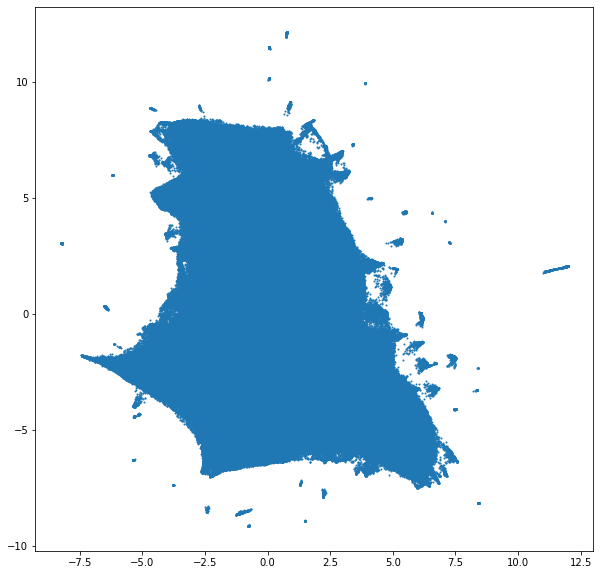

In [195]:
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0],
           embedding[:,1],
           s=1)

In [210]:
only_IDs = ['_'.join(f.split('_')[:-1]) for f in image_paths]

In [214]:
df_ID_groups = df.groupby('ID').groups

In [275]:
pd.DataFrame(only_IDs, columns=['ID'])

,ID
0,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0
2,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0
3,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0
4,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0
...,...
1607415,ffeae6f0-bbc9-11e8-b2bc-ac1f6b6435d0
1607416,ffeae6f0-bbc9-11e8-b2bc-ac1f6b6435d0
1607417,ffeae6f0-bbc9-11e8-b2bc-ac1f6b6435d0
1607418,ffeae6f0-bbc9-11e8-b2bc-ac1f6b6435d0


In [281]:
df[labels + ['ID','cell_type']]

,"actin filaments,focal adhesion sites",aggresome,"centrosome,centriolar satellite",cytosol,endoplasmic reticulum,golgi apparatus,intermediate filaments,microtubules,mitochondria,mitotic spindle,...,nuclear bodies,nuclear membrane,nuclear speckles,nucleoli,nucleoli fibrillar center,nucleoplasm,"plasma membrane,cell junctions","vesicles,peroxisomes,endosomes,lysosomes,lipid droplets,cytoplasmic bodies",ID,cell_type
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,10005_921_B9_1,A-431
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,10005_921_B9_1,A-431
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,10005_921_B9_1,A-431
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,10005_921_B9_1,A-431
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,10005_921_B9_1,A-431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629689,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0,MCF7
629690,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0,MCF7
629691,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0,MCF7
629692,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0,MCF7


In [326]:
np.array(cell_lines)[ID_groups['ffeae6f0-bbc9-11e8-b2bc-ac1f6b6435d0']]

array(['RH-30', 'RH-30', 'RH-30', 'RH-30', 'RH-30', 'RH-30', 'RH-30',
       'RH-30', 'RH-30', 'RH-30', 'RH-30', 'RH-30', 'RH-30', 'RH-30',
       'RH-30', 'RH-30', 'RH-30', 'RH-30', 'RH-30', 'RH-30', 'RH-30',
       'RH-30', 'RH-30', 'RH-30', 'RH-30'], dtype='<U32')

In [301]:
ID_groups = pd.DataFrame(only_IDs).groupby(0).groups
proteins = np.zeros((len(only_IDs), 19))
cell_lines = np.zeros((len(only_IDs))).astype(str)
for ID in tqdm(sorted(ID_groups.keys())):
    cell_lines[ID_groups[ID]] = df.iloc[df_ID_groups[ID]].cell_type.values[0]
    proteins[ID_groups[ID],:] = df.iloc[df_ID_groups[ID]][labels].values.astype(int)[0]
cell_lines = np.array(cell_lines)
proteins = np.stack(proteins)    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89619/89619 [00:58<00:00, 1538.65it/s]


In [ ]:
import pandas as pd
i = only_IDs
c = np.array(cell_lines)
p = np.array(proteins)
f = features
unique_IDs = sorted(ID_groups.keys())
averaged_features = [f[ID_groups[ID]].mean(axis=0) for ID in unique_IDs]
averaged_protein = [p[ID_groups[ID][0]] for ID in unique_IDs]
averaged_cell_line = [(c)[ID_groups[ID][0]] for ID in unique_IDs]

averaged_features = np.stack(averaged_features)
averaged_protein = np.stack(averaged_protein)
averaged_cell_line = np.stack(averaged_cell_line)

In [316]:
averaged_scaled_features = StandardScaler().fit_transform(averaged_features)
reducer = umap.UMAP()
averaged_embedding = reducer.fit_transform(averaged_scaled_features)

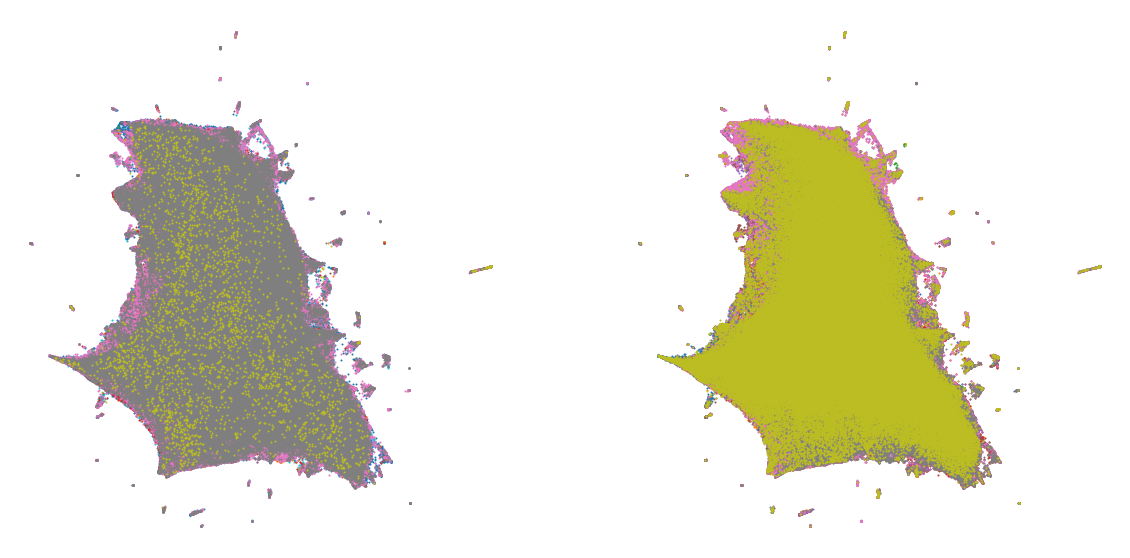

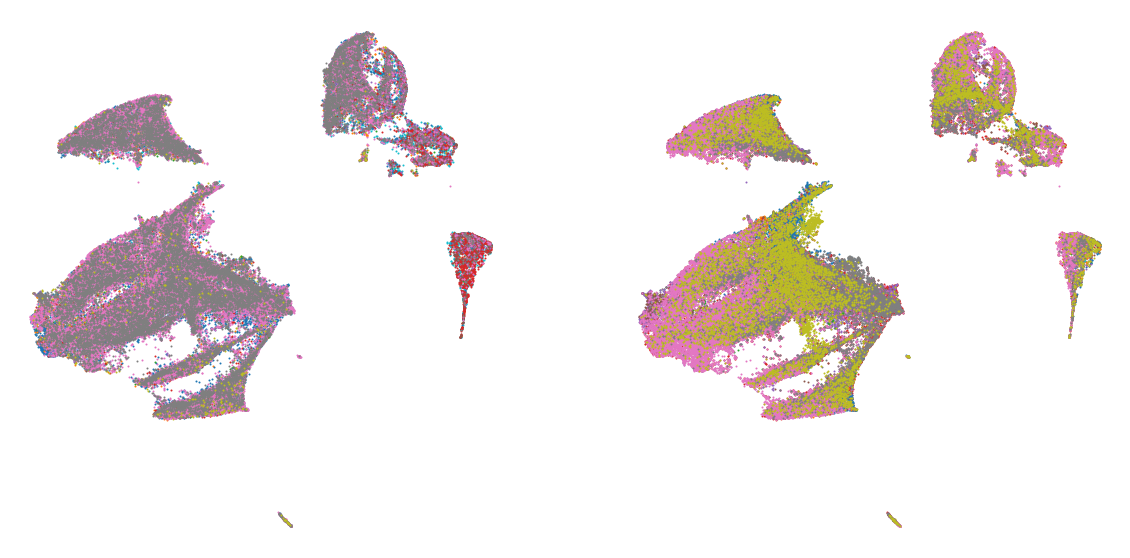

In [333]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
cell_lines = np.array(cell_lines)
unique_cells = np.unique(cell_lines)
for u in unique_cells:
    indices = np.where((cell_lines) == u)[0]
    axes[0].scatter(embedding[indices,0],
               embedding[indices,1],
               s=1)    
    axes[0].axis('off')    
for i in range(19):
    indices = np.where(proteins[:,i])[0]
    axes[1].scatter(embedding[indices,0],
               embedding[indices,1],
               s=1)  
    axes[1].axis('off')

fig, axes = plt.subplots(1,2,figsize=(20,10))
unique_cells = np.unique(averaged_cell_line)
averaged_cell_line = np.array(averaged_cell_line)
averaged_protein = np.array(averaged_protein)
for u in unique_cells:
    indices = np.where(averaged_cell_line == u)[0]
    axes[0].scatter(averaged_embedding[indices,0],
                    averaged_embedding[indices,1],
                    s=1)    
    axes[0].axis('off')    

for i in range(19):
    indices = np.where(averaged_protein[:,i])[0]
    axes[1].scatter(averaged_embedding[indices,0],
                    averaged_embedding[indices,1],
                    s=1)  
    axes[1].axis('off')


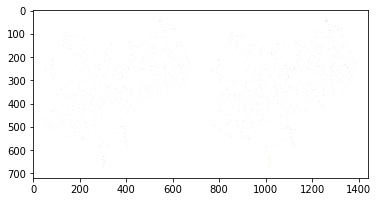

In [336]:
plt.imshow(plt.imread('/scr/mdoron/Dino4Cells/kaggle_comparison/HPA-singlecell-2nd-dual-head-pipeline/average.png'))